In [1]:
#Basic libraries
import pandas as pd
import numpy as np

#Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#Importing required metrices and model for the dataset
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression,Lasso,ElasticNet,Ridge
from sklearn.metrics import r2_score, mean_absolute_error,mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

###### Loading the dataset

In [2]:
#Loading the data
df=pd.read_csv('olxcardata.csv')  
df.head()  

,Unnamed: 0,name,year,selling_price,km_driven,fuel,transmission
0,0,Hyundai,2017,"5,25,000","2,200 km",Petrol,Manual
1,1,Hyundai,2013,"5,95,000","91,500 km",Diesel,Manual
2,2,Ford,2017,"7,75,000","36,000 km",Diesel,Manual
3,3,Honda,2015,"4,00,000","90,000 km",Diesel,Manual
4,4,Maruti Suzuki,2010,"2,30,000","40,000 km",Petrol,Manual


In [3]:
df.shape    

(10000, 7)

In [4]:
df.drop(['Unnamed: 0'],axis=1,inplace=True)
df.head()  

,name,year,selling_price,km_driven,fuel,transmission
0,Hyundai,2017,"5,25,000","2,200 km",Petrol,Manual
1,Hyundai,2013,"5,95,000","91,500 km",Diesel,Manual
2,Ford,2017,"7,75,000","36,000 km",Diesel,Manual
3,Honda,2015,"4,00,000","90,000 km",Diesel,Manual
4,Maruti Suzuki,2010,"2,30,000","40,000 km",Petrol,Manual


In [5]:
#Checking the datatypes of the dataset features
df.dtypes

name             object
year             object
selling_price    object
km_driven        object
fuel             object
transmission     object
dtype: object

We can see that all the data has been of object datatype and we need to convert them into numerical data before the model building process.

In [6]:
#Checking for missing data
df.isnull().sum()

name             0
year             0
selling_price    0
km_driven        0
fuel             0
transmission     0
dtype: int64

As we can see, there are no null values in the dataset and we can proceed further

<AxesSubplot:>

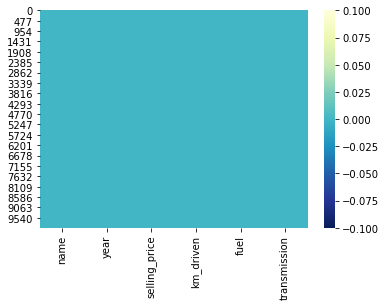

In [7]:
#Plotting heatmap for missing data
sns.heatmap(df.isnull(), cmap='YlGnBu_r')

###### Data Cleaning

In [8]:
#Copying the dataframe
df1=df.copy()

In [9]:
#Removing ',' from km_driven column
df1['km_driven']=df1['km_driven'].apply(lambda x: x.replace(',','') if x!='-' else '-')
df1.head()

,name,year,selling_price,km_driven,fuel,transmission
0,Hyundai,2017,"5,25,000",2200 km,Petrol,Manual
1,Hyundai,2013,"5,95,000",91500 km,Diesel,Manual
2,Ford,2017,"7,75,000",36000 km,Diesel,Manual
3,Honda,2015,"4,00,000",90000 km,Diesel,Manual
4,Maruti Suzuki,2010,"2,30,000",40000 km,Petrol,Manual


In [10]:
#Removing km word from km_driven
df1['km_driven']=df1['km_driven'].apply(lambda x: int(x.split(' ')[0]) if x!='-' else 0)
df1.head()  

,name,year,selling_price,km_driven,fuel,transmission
0,Hyundai,2017,"5,25,000",2200,Petrol,Manual
1,Hyundai,2013,"5,95,000",91500,Diesel,Manual
2,Ford,2017,"7,75,000",36000,Diesel,Manual
3,Honda,2015,"4,00,000",90000,Diesel,Manual
4,Maruti Suzuki,2010,"2,30,000",40000,Petrol,Manual


In [11]:
try:
    df1['selling_price']=df1['selling_price'].apply(lambda x: x.split(' ')[1] if x!='-' else '0')
except IndexError:
    pass

In [12]:
try:
    df1['selling_price']=df1['selling_price'].apply(lambda x: str(x.replace(',', '')))
except ValueError:
    pass

In [13]:
df1.head()

,name,year,selling_price,km_driven,fuel,transmission
0,Hyundai,2017,525000,2200,Petrol,Manual
1,Hyundai,2013,595000,91500,Diesel,Manual
2,Ford,2017,775000,36000,Diesel,Manual
3,Honda,2015,400000,90000,Diesel,Manual
4,Maruti Suzuki,2010,230000,40000,Petrol,Manual


In [14]:
df1['selling_price']=df1['selling_price'].str.strip()  

In [15]:
df1['selling_price']=pd.to_numeric(df1['selling_price'].str.replace('-','0'), errors='coerce')  

In [16]:
df1['selling_price']=df1.selling_price.astype(float)  

In [17]:
df1.dtypes

name              object
year              object
selling_price    float64
km_driven          int64
fuel              object
transmission      object
dtype: object

In [18]:
#Handling year column
df1['year']=df1['year'].apply(lambda x: int(x.strip()[0:4]) if x!='-' else 0)  

In [19]:
med_years=df1['year'].median()  #Finding the median value
med_years

2014.0

In [20]:
df1['year']=df1['year'].apply(lambda x: x if x!=0 else med_years)  

In [21]:
df1.head()   #Checking the dataset

,name,year,selling_price,km_driven,fuel,transmission
0,Hyundai,2017.0,525000.0,2200,Petrol,Manual
1,Hyundai,2013.0,595000.0,91500,Diesel,Manual
2,Ford,2017.0,775000.0,36000,Diesel,Manual
3,Honda,2015.0,400000.0,90000,Diesel,Manual
4,Maruti Suzuki,2010.0,230000.0,40000,Petrol,Manual


In [22]:
df1['year']=df1['year'].astype(int)   

In [23]:
df1.dtypes

name              object
year               int32
selling_price    float64
km_driven          int64
fuel              object
transmission      object
dtype: object

In [24]:
#Handling fuel data
df1['fuel'].value_counts()

Diesel           5345
Petrol           4386
CNG & Hybrids     108
CNG                57
-                  56
LPG                48
Name: fuel, dtype: int64

In [25]:
#Calculating mode
tmode=df1['fuel'].mode()
tmode

0    Diesel
dtype: object

In [26]:
#Replacing - with Other kind of fuel
df1['fuel']=df1['fuel'].apply(lambda x: x if x!='-' else 'Other')

#Checking the data
df1['fuel'].unique()

array(['Petrol', 'Diesel', 'Other', 'CNG & Hybrids', 'LPG', 'CNG'],
      dtype=object)

In [27]:
#Handling transmission data
df1['transmission'].value_counts()

Manual       8408
Automatic    1402
-             190
Name: transmission, dtype: int64

In [28]:
#Replacing - with Manual 
df1['transmission']=df1['transmission'].apply(lambda x: x if x!='-' else 'Manual')

#Checking the data
df1['transmission'].unique()

array(['Manual', 'Automatic'], dtype=object)

In [29]:
#Handling the car name
df1['name'].value_counts()

Maruti Suzuki                              602
Hyundai                                    348
Honda                                      132
Mahindra                                   128
Maruti Swift Dzire VDI                     128
                                          ... 
Hyundai Elite i20 Petrol Magna Exective      1
Tata Indigo VS                               1
Mahindra Verito 1.6 G6 Executive BSIII       1
Maruti Omni 5 Str STD                        1
Chevrolet Enjoy 1.3 TCDi LTZ 8               1
Name: name, Length: 2056, dtype: int64

While scraping the data, we found that there were some missing data which was replaced by - . Now, we can replace them by the car name with max weightage.

In [30]:
#Replacing - with Hyundai 
df1['name']=df1['name'].apply(lambda x: x if x!='-' else 'Hyundai')

#Checking the data
df1['name'].value_counts()

Maruti Suzuki                                 602
Hyundai                                       392
Honda                                         132
Mahindra                                      128
Maruti Swift Dzire VDI                        128
                                             ... 
Mahindra Verito 1.6 G6 Executive BSIII          1
Maruti Omni 5 Str STD                           1
Maruti Vitara Brezza ZXI Plus AT Dual Tone      1
Volvo XC60 Inscription D5 BSIV                  1
Chevrolet Enjoy 1.3 TCDi LTZ 8                  1
Name: name, Length: 2055, dtype: int64

In [31]:
#Checking the dataframe
df1.head()

,name,year,selling_price,km_driven,fuel,transmission
0,Hyundai,2017,525000.0,2200,Petrol,Manual
1,Hyundai,2013,595000.0,91500,Diesel,Manual
2,Ford,2017,775000.0,36000,Diesel,Manual
3,Honda,2015,400000.0,90000,Diesel,Manual
4,Maruti Suzuki,2010,230000.0,40000,Petrol,Manual


In [32]:
#Copying the dataframe
df=df1.copy()

In [33]:
df.head()

,name,year,selling_price,km_driven,fuel,transmission
0,Hyundai,2017,525000.0,2200,Petrol,Manual
1,Hyundai,2013,595000.0,91500,Diesel,Manual
2,Ford,2017,775000.0,36000,Diesel,Manual
3,Honda,2015,400000.0,90000,Diesel,Manual
4,Maruti Suzuki,2010,230000.0,40000,Petrol,Manual


We can see that all the data has been handled and cleaned and after this step, we can proceed further with data analysis steps.

## Univariate and Bivariate Analysis

Diesel           5345
Petrol           4386
CNG & Hybrids     108
CNG                57
Other              56
LPG                48
Name: fuel, dtype: int64


<AxesSubplot:xlabel='fuel', ylabel='count'>

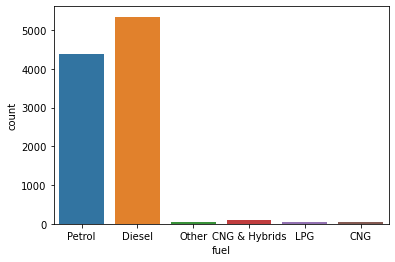

In [34]:
#Plotting the countplot for fuel
print(df['fuel'].value_counts())
sns.countplot(df['fuel'])

We can see that Diesel and Petrol are the maximum fuels used by cars, whereas CNG and LPG are the least used.

Manual       8598
Automatic    1402
Name: transmission, dtype: int64


<AxesSubplot:xlabel='transmission', ylabel='count'>

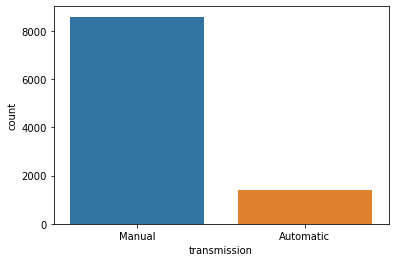

In [35]:
#Plotting the countplot for transmission
print(df['transmission'].value_counts())
sns.countplot(df['transmission'])

Most of the cars have manual transmission as the highest weightage

2017    1099
2016    1021
2018     983
2015     975
2012     844
2014     842
2013     802
2011     733
2019     642
2010     519
2009     366
2008     300
2007     207
2006     148
2020     132
2005     112
2004      71
2003      55
2002      45
1999      24
2000      24
2001      16
1997      11
2021      10
1998       9
1996       3
1994       3
1995       2
1983       1
1991       1
Name: year, dtype: int64


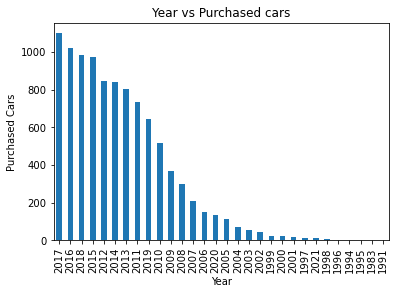

In [36]:
#Value_counts for year
print(df['year'].value_counts())

#Plotting year vs no of cars
purchased_car_per_year = df['year'].value_counts()
purchased_car_per_year.plot(kind='bar')
plt.xlabel("Year")
plt.ylabel("Purchased Cars")
plt.title("Year vs Purchased cars")
plt.show()

Maximum number of cars are bought in the year 2017 whereas minimum number of cars were brought in 1991 and 1983.

We can see that manual cars have higher price range than automatic type cars though the distribution were skewed to the right. We can also see the increase of cars between 2010 and 2020.

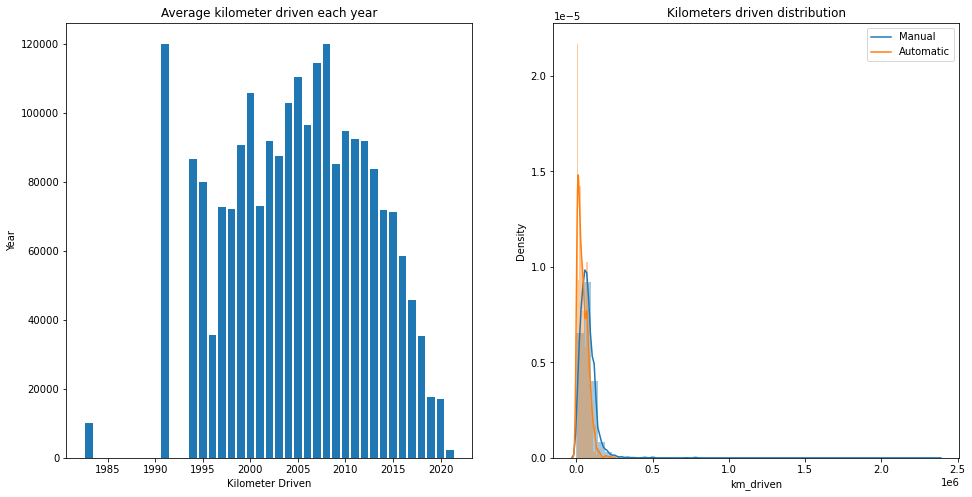

In [41]:
#Plotting for year vs km_driven
km_mean = df.groupby('year')['km_driven'].mean()

fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(16,8))

ax[0].bar(km_mean.index,km_mean)
sns.distplot(manual['km_driven'],ax=ax[1])
sns.distplot(automatic['km_driven'],ax=ax[1])

ax[0].set_title('Average kilometer driven each year')
ax[0].set_xlabel('Kilometer Driven')
ax[0].set_ylabel('Year')

ax[1].set_title('Kilometers driven distribution')
ax[1].legend(['Manual','Automatic'])

plt.show()

We can see that average kilometers driven rises up from 1995 until 2008 and linearly goes down until 2020. We can also see some outliers present in the distribution plot.

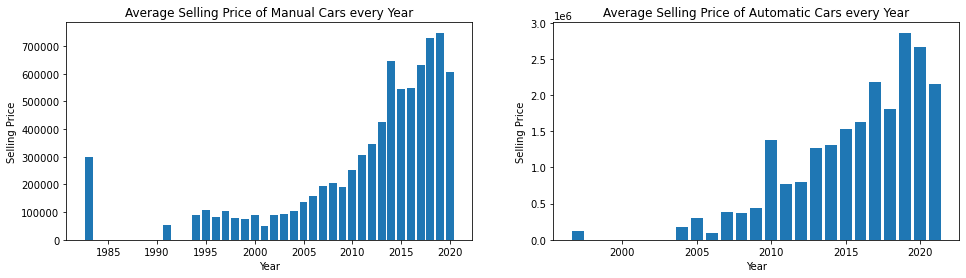

In [42]:
#Year and selling price
year_mean_manual = df[df['transmission']=='Manual'].groupby('year')['selling_price'].mean()
year_mean_automatic = df[df['transmission']=='Automatic'].groupby('year')['selling_price'].mean()

fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(16,4))

ax[0].bar(year_mean_manual.index,year_mean_manual)
ax[1].bar(year_mean_automatic.index,year_mean_automatic)

ax[0].set_title('Average Selling Price of Manual Cars every Year')
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Selling Price')

ax[1].set_title('Average Selling Price of Automatic Cars every Year')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Selling Price')

plt.show()

# Converting categorical data into numerical data

In [43]:
#Converting fuel and transmission data using LabelEncoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
col=['fuel','transmission']  
for i in col:
    df[i] = le.fit_transform(df[i])

In [44]:
#Checking the dataset
df.head()

,name,year,selling_price,km_driven,fuel,transmission
0,Hyundai,2017,525000.0,2200,5,1
1,Hyundai,2013,595000.0,91500,2,1
2,Ford,2017,775000.0,36000,2,1
3,Honda,2015,400000.0,90000,2,1
4,Maruti Suzuki,2010,230000.0,40000,5,1


By using label encoder, we had converted object data into numerical data

In [45]:
df.describe()    

,year,selling_price,km_driven,fuel,transmission
count,10000.00000,1.000000e+04,1.000000e+04,10000.00000,10000.000000
mean,2013.69860,6.608371e+05,6.914651e+04,3.30960,0.859800
std,4.02124,1.204508e+06,5.868048e+04,1.51439,0.347212
min,1983.00000,0.000000e+00,0.000000e+00,0.00000,0.000000
25%,2011.00000,2.549990e+05,3.500000e+04,2.00000,1.000000
50%,2014.00000,4.500000e+05,6.000000e+04,2.00000,1.000000
75%,2017.00000,6.770000e+05,9.000000e+04,5.00000,1.000000
max,2021.00000,6.300000e+07,2.360457e+06,5.00000,1.000000


Observations:

1.There is not much difference between the mean and the median

2.The minimum value is 0 for all other columns.

3.The 75th percentile and max value difference for km_driven column is high and it is due to the presence of outliers.

In [46]:
#Checking correlation of the dataset
corr=df.corr()  
corr

,year,selling_price,km_driven,fuel,transmission
year,1.000000,0.278422,-0.391988,-0.050646,-0.234196
selling_price,0.278422,1.000000,-0.147619,-0.121624,-0.400351
km_driven,-0.391988,-0.147619,1.000000,-0.247807,0.182361
fuel,-0.050646,-0.121624,-0.247807,1.000000,-0.028709
transmission,-0.234196,-0.400351,0.182361,-0.028709,1.000000


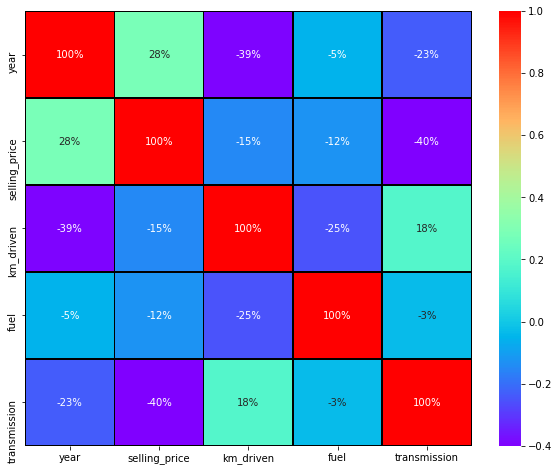

In [47]:
#Plotting heatmap for visualizing the correlation
plt.figure(figsize=(10,8))
sns.heatmap(corr,linewidth=0.5,linecolor='black',fmt='.0%',cmap='rainbow',annot=True)
plt.show()

Observations:

1.There are more negative correlations present in the dataset

2.Highest positive correlated column has a value of 28%.

3.Highest negatively correlated column has a value of -40%

4.Positively correlated columns have a high impact with the target variable whereas negatively correlated columns have less or zero impact with the target variable.

Text(0.5, 1.0, 'Correlation with Target variable')

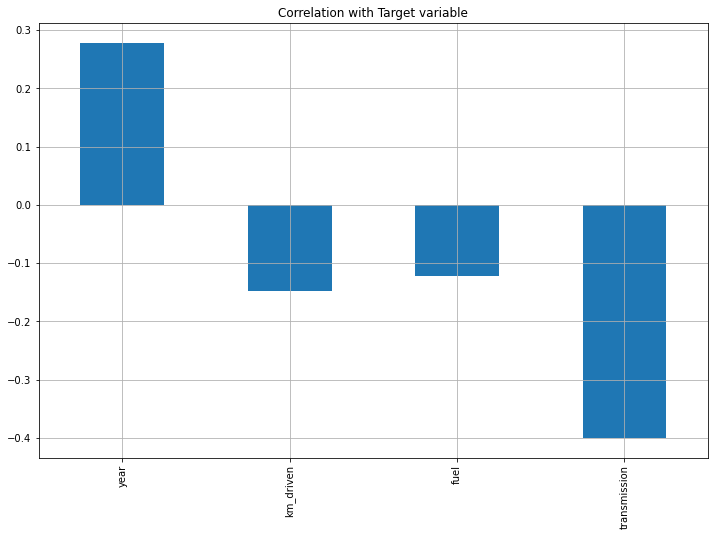

In [49]:
#Correlation with target variable
plt.figure(figsize=(12,8))
df.drop('selling_price',axis=1).corrwith(df['selling_price']).plot(kind='bar',grid=True)
plt.title('Correlation with Target variable')

We can see that year column is the only highly correlated column

In [50]:
#Dropping name column
df.drop(['name'],axis=1,inplace=True)

# Checking skewness

In [51]:
df.skew()

year             -0.970990
selling_price    28.995597
km_driven         9.944101
fuel              0.167063
transmission     -2.072925
dtype: float64

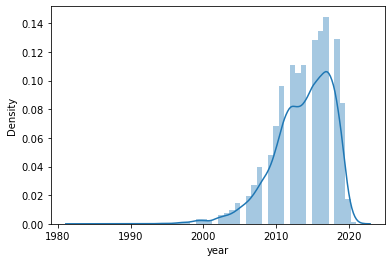

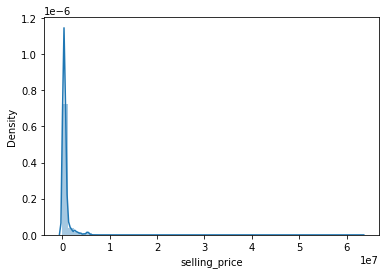

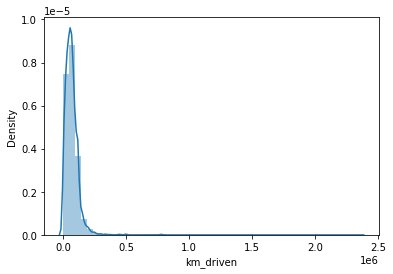

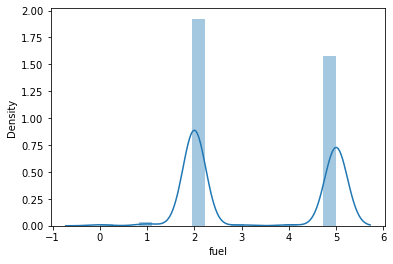

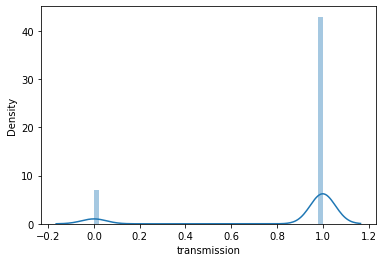

In [52]:
#Plotting distplot for checking the distribution of skewness
for col in df.describe().columns:
    sns.distplot(df[col])
    plt.show()

Large skewness is present in selling_price and km_driven columns and it is due to the presence of outliers

In [53]:
collist=df.columns.values 
ncol=20
nrows=20

We can see there are outliers and it can be handled by using z-score method

In [55]:
from scipy.stats import zscore
import numpy as np
z=np.abs(zscore(df))   
threshold=3    
np.where(z>3)

(array([   6,   13,   46,   53,  166,  173,  299,  311,  312,  321,  328,
         329,  335,  355,  377,  406,  413,  539,  551,  552,  568,  569,
         595,  617,  641,  682,  703,  705,  733,  766,  846,  899,  911,
         912,  928,  929,  955,  977, 1007, 1132, 1135, 1136, 1139, 1148,
        1170, 1177, 1186, 1288, 1316, 1371, 1384, 1385, 1401, 1410, 1423,
        1424, 1461, 1647, 1660, 1661, 1774, 1808, 1886, 1998, 1999, 2025,
        2045, 2071, 2078, 2091, 2092, 2097, 2110, 2111, 2116, 2129, 2130,
        2135, 2148, 2149, 2216, 2237, 2379, 2432, 2468, 2474, 2562, 2629,
        2710, 2723, 2724, 2775, 2810, 2815, 2858, 2871, 2872, 2882, 2972,
        2997, 3006, 3036, 3094, 3140, 3145, 3272, 3327, 3340, 3402, 3424,
        3579, 3584, 3631, 3644, 3645, 3664, 3677, 3678, 3726, 3805, 3818,
        3886, 3938, 3977, 3999, 4046, 4079, 4092, 4093, 4097, 4120, 4237,
        4240, 4310, 4378, 4409, 4422, 4423, 4486, 4508, 4517, 4530, 4531,
        4583, 4584, 4641, 4832, 4845, 

In [56]:
#Removing outliers
df_new=df[(z<3).all(axis=1)]
df_new

,year,selling_price,km_driven,fuel,transmission
0,2017,525000.0,2200,5,1
1,2013,595000.0,91500,2,1
2,2017,775000.0,36000,2,1
3,2015,400000.0,90000,2,1
4,2010,230000.0,40000,5,1
...,...,...,...,...,...
9995,2012,325000.0,65000,5,1
9996,2018,290000.0,85000,1,1
9997,2010,320000.0,72000,5,1
9998,2012,185000.0,70000,2,1


In [57]:
df.shape   

(10000, 5)

In [58]:
df_new.shape  

(9660, 5)

In [59]:
percentage_loss=((340)/10000)*100   
print(percentage_loss)

3.4000000000000004


We can see that less number of data has been removed and it's not a big loss

###### Preparing dataset for model training

In [60]:
df_x=df_new.drop('selling_price',axis=1)   
y=df_new['selling_price']    

In [61]:
#Checking x data
df_x.head()

,year,km_driven,fuel,transmission
0,2017,2200,5,1
1,2013,91500,2,1
2,2017,36000,2,1
3,2015,90000,2,1
4,2010,40000,5,1


In [62]:
#Checking y data after splitting
y.head()

0    525000.0
1    595000.0
2    775000.0
3    400000.0
4    230000.0
Name: selling_price, dtype: float64

# Treating skewness

In [63]:
#We are treating skewness by using square root transform
for col in df_x.skew().index:
    if col in df_x.describe().columns:
        if df_x[col].skew()>0.55:
            df_x[col]=np.sqrt(df_x[col])
        if df_x[col].skew()<-0.55:
            df_x[col]=np.sqrt(df_x[col])  

In [64]:
df_x.skew()   #Checking skewness after treating it

year           -0.656801
km_driven      -0.173734
fuel            0.156582
transmission   -2.214140
dtype: float64

We can see that skewness has been treated and we can proceed further model building process

# Scaling the data

Sometimes model can be biased to higher values in dataset, so it is better to scale the dataset so that we can bring all the columns in common range. We can use StandardScaler here.

In [65]:
#Scaling the dataset using StandardScaler
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
x=sc.fit_transform(df_x)
x=pd.DataFrame(x,columns=df_x.columns)
x

,year,km_driven,fuel,transmission
0,0.858876,-2.329023,1.110111,0.38482
1,-0.215883,0.690959,-0.870253,0.38482
2,0.858876,-0.641323,-0.870253,0.38482
3,0.321630,0.661541,-0.870253,0.38482
4,-1.022654,-0.520052,1.110111,0.38482
...,...,...,...,...
9655,-0.484740,0.129245,1.110111,0.38482
9656,1.127400,0.561668,-1.530374,0.38482
9657,-1.022654,0.287309,1.110111,0.38482
9658,-0.484740,0.242963,-0.870253,0.38482


# Model Building

In [66]:
#Finding the best random state and r2_score
for i in range(42,100):
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.20,random_state=i)
    lr=LinearRegression()
    lr.fit(x_train,y_train)
    pred_train=lr.predict(x_train)
    pred_test=lr.predict(x_test)
    if round(r2_score(y_train,pred_train)*100,1)==round(r2_score(y_test,pred_test)*100,1):
        print('At random state',i,',the model performs well')
        print('Training r2_score is: ',r2_score(y_train,pred_train)*100)
        print('Testing r2_score is: ',r2_score(y_test,pred_test)*100)

At random state 48 ,the model performs well
Training r2_score is:  49.815054894606924
Testing r2_score is:  49.78050062810894
At random state 73 ,the model performs well
Training r2_score is:  49.81662674234254
Testing r2_score is:  49.75466781460837


We can see that at random_state=48, the best r2_score is obtained so that we can create our train_test_split with this random state.

In [67]:
#Creating train_test_split using best random_state
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=48,test_size=.20)

# Finding the best model

In [68]:
LR=LinearRegression()
l=Lasso()
en=ElasticNet()
rd=Ridge()
dtr=DecisionTreeRegressor()
knr=KNeighborsRegressor()
rf=RandomForestRegressor()
ab=AdaBoostRegressor()
gb=GradientBoostingRegressor()

In [69]:
models= []
models.append(('Linear Regression',LR))
models.append(('Lasso Regression',l))
models.append(('Elastic Net Regression',en))
models.append(('Ridge Regression',rd))
models.append(('Decision Tree Regressor',dtr))
models.append(('KNeighbors Regressor',knr))
models.append(('RandomForestRegressor',rf))
models.append(('AdaBoostRegressor',ab))
models.append(('GradientBoostingRegressor',gb))

In [70]:
#Finding the required metrices for all models together using a for loop
Model=[]
score=[]
cvs=[]
sd=[]
mae=[]
mse=[]
rmse=[]
for name,model in models:
    print('******************************',name,'***************************')
    print('\n')
    Model.append(name)
    model.fit(x_train,y_train)
    print(model)
    pre=model.predict(x_test)
    print('\n')
    AS=r2_score(y_test,pre)
    print('r2_score: ',AS)
    score.append(AS*100)
    print('\n')
    sc=cross_val_score(model,x,y,cv=5,scoring='r2').mean()
    print('cross_val_score: ',sc)
    cvs.append(sc*100)
    print('\n')
    std=cross_val_score(model,x,y,cv=5,scoring='r2').std()
    print('Standard Deviation: ',std)
    sd.append(std)
    print('\n')
    MAE=mean_absolute_error(y_test,pre)
    print('Mean Absolute Error: ',MAE)
    mae.append(MAE)
    print('\n')
    MSE=mean_squared_error(y_test,pre)
    print('Mean Squared Error: ',MSE)
    mse.append(MSE)
    print('\n')
    RMSE=np.sqrt(mean_squared_error(y_test,pre))
    print('Root Mean Squared Error: ',RMSE)
    rmse.append(RMSE)
    print('\n\n')

****************************** Linear Regression ***************************


LinearRegression()


r2_score:  0.49780500628108937


cross_val_score:  0.49634394859423203


Standard Deviation:  0.01611848887516134


Mean Absolute Error:  245143.3933160851


Mean Squared Error:  159654922494.05557


Root Mean Squared Error:  399568.4202912632



****************************** Lasso Regression ***************************


Lasso()


r2_score:  0.49780509253388605


cross_val_score:  0.4963439420374778


Standard Deviation:  0.01611829795047155


Mean Absolute Error:  245142.90969085626


Mean Squared Error:  159654895073.06622


Root Mean Squared Error:  399568.3859780028



****************************** Elastic Net Regression ***************************


ElasticNet()


r2_score:  0.45587343179152995


cross_val_score:  0.45318972356504583


Standard Deviation:  0.01535342392589892


Mean Absolute Error:  234774.44047653952


Mean Squared Error:  172985565688.26358


Root Mean Squared 

In [71]:
#Finalizing the result
result=pd.DataFrame({'Model':Model, 'r2_score': score, 'Cross_val_score':cvs, 'Standard_deviation':sd,
                    'Mean_absolute_error':mae, 'Mean_squared_error':mse, 'Root_Mean_Squared_error':rmse})
result

,Model,r2_score,Cross_val_score,Standard_deviation,Mean_absolute_error,Mean_squared_error,Root_Mean_Squared_error
0,Linear Regression,49.780501,49.634395,0.016118,245143.393316,1.596549e+11,399568.420291
1,Lasso Regression,49.780509,49.634394,0.016118,245142.909691,1.596549e+11,399568.385978
2,Elastic Net Regression,45.587343,45.318972,0.015353,234774.440477,1.729856e+11,415915.334760
3,Ridge Regression,49.780536,49.634433,0.016118,245134.259261,1.596548e+11,399568.281071
4,Decision Tree Regressor,74.373282,74.108579,0.073529,143620.442342,8.147098e+10,285431.209631
5,KNeighbors Regressor,74.761909,71.831772,0.037407,152245.250104,8.023548e+10,283258.675692
6,RandomForestRegressor,77.578361,77.119771,0.053823,143078.180636,7.128157e+10,266986.094827
7,AdaBoostRegressor,52.939289,50.707491,0.051023,247539.505973,1.496127e+11,386797.992642
8,GradientBoostingRegressor,70.246173,68.762676,0.015560,179608.295180,9.459164e+10,307557.542669


We can see that Random Forest Regressor and KNeighbors Regressor are performing well compared to other algorithms. Now we will try Hyperparameter Tuning to find out the best parameters and try to increase the scores.

# Hyperparameter Tuning

## Random Forest Regressor

In [72]:
#Creating parameter list to pass in GridSearchCV
parameters={'criterion':['mse','mae'],'n_estimators':[50,100,500],'max_features':['auto','sqrt','log2']}

In [73]:
#Using GridSearchCV to run the parameters and checking final accuracy
rf=RandomForestRegressor()
grid=GridSearchCV(rf,parameters,cv=5,scoring='r2')
grid.fit(x_train,y_train)
print(grid.best_params_)  #Printing the best parameters obtained
print(grid.best_score_) #Mean cross-validated score of best_estimator

{'criterion': 'mse', 'max_features': 'auto', 'n_estimators': 100}
0.7585194316770476


In [74]:
#Using the best parameters obtained
RF=RandomForestRegressor(random_state=48, n_estimators=100, criterion='mse', max_features='auto')
RF.fit(x_train,y_train)
pred=RF.predict(x_test)
print('r2_score: ',r2_score(y_test,pred)*100)
print('Cross validation score: ',cross_val_score(RF,x,y,cv=5,scoring='r2').mean()*100)
print('Standard deviation: ',cross_val_score(RF,x,y,cv=5,scoring='r2').std())
print('\n')
print('Mean absolute error: ',mean_absolute_error(y_test,pred))
print('Mean squared error: ',mean_squared_error(y_test,pred))
print('Root Mean squared error: ',np.sqrt(mean_squared_error(y_test,pred))) 

r2_score:  78.02640255481647
Cross validation score:  77.0128999250369
Standard deviation:  0.0525850724267253


Mean absolute error:  142169.8222155508
Mean squared error:  69857187763.80247
Root Mean squared error:  264305.10355231975


After applying Hyperparameter Tuning, we can see that RandomForestRegressor is the best performing algorithm among all other algorithms as it is giving a r2_score of 78.02 and cross validation score of 77.01. It has also the less amount of error values obtained. Lesser the RMSE score, the better the model. Now we will finalize the model. The scores are improved; r2_score from 77.57 to 78.02 and cross_val_score from 77.11 to 77.01, which is good

In [78]:
rf_prediction=RF.predict(x)
print('Predictions of Random Forest Regressor: ',rf_prediction)

Predictions of Random Forest Regressor:  [523000.         644522.88752914 760124.50877554 ... 320000.
 276868.90269236 896053.87848263]


In [86]:
#Saving the model
import pickle
filename='Car_Price_Prediction.pkl'  
pickle.dump(RF,open(filename,'wb'))